# Spectral Extraction using `stark`

We have reduced calibrated data from `uncal` data using the jwst pipeline in another notebook. In the present notebook, we will extract timeseries of stellar spectra from those calibrated data. We will use `stark` package to do this.

The basic algorithm is similar to that from Horne's algorithm ([Horne 1986](https://iopscience.iop.org/article/10.1086/131801)) -- instead of using polynomials as a function of wavelength as in Horne (1986), `stark` fit splines to find a robust estimate of the stellar PSF. We derive one single PSF for _all_ frames (since pointing is stable and the background/sky is roughly the same, i.e., PSF doesn't change much with time) for a given wavelength (because PSF does change as a function of wavelength): to achieve this in practice we fit a 2D spline as a function of spatial coordinate (i.e., distance from the trace) and wavelength. Once we have estimate of PSF, we can use it to derive stellar spectra for each frame. This will give us transit lightcurves for each wavelengths. Averaging over wavelength would give us white-light lightcurve.

We will fit a transit lightcurve to the data once we have white-light lightcurve.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import utils
from stark import SingleOrderPSF, optimal_extract
from astropy.stats import mad_std
from exotoolbox.utils import tdur
import pickle
from tqdm import tqdm
from pathlib import Path
from poetss import poetss
from scipy.ndimage import median_filter
import matplotlib.gridspec as gd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import juliet

import multiprocessing
multiprocessing.set_start_method('fork')

In [2]:
visit = 'NRSG395H'
catwoman = False      # Type of White-light LC fitting
detector = 'nrs1'
aprad = 7

# Input and Output paths
p1 = '/'.join(os.getcwd().split('/')[:-1])
pin = p1 + '/RateInts/Corr_' + visit
pout = p1 + '/NRSG395H/Outputs'
if not Path(pout + '/Figures').exists():
    os.mkdir(pout + '/Figures')

## Segment!!!
segs = []
for i in range(3):
    if i < 9:
        segs.append('00' + str(i+1))
    else:
        segs.append('0' + str(i+1))
xstart, xend = 650, 2040

corrected_data = np.load(pin + '/Corrected_data_' + detector + '_seg' + segs[0] + '.npy')
corrected_errs = np.load(pin + '/Corrected_errors_' + detector + '_seg' + segs[0] + '.npy')
mask_bcr = np.load(pin + '/Mask_bcr_' + detector + '_seg' + segs[0] + '.npy')
time_bjd = np.load(pin + '/Times_bjd_' + detector + '_seg' + segs[0] + '.npy')
for i in range(len(segs)-1):
    ## Data
    data1 = np.load(pin + '/Corrected_data_' + detector + '_seg' + segs[i+1] + '.npy')
    corrected_data = np.vstack((corrected_data, data1))
    ## Errors
    errs1 = np.load(pin + '/Corrected_errors_' + detector + '_seg' + segs[i+1] + '.npy')
    corrected_errs = np.vstack((corrected_errs, errs1))
    ## Masks
    msk1 = np.load(pin + '/Mask_bcr_' + detector + '_seg' + segs[i+1] + '.npy')
    mask_bcr = np.vstack((mask_bcr, msk1))
    ## Times
    tim12 = np.load(pin + '/Times_bjd_' + detector + '_seg' + segs[i+1] + '.npy')
    time_bjd = np.hstack((time_bjd, tim12))

time_bjd = time_bjd + 2400000.5
nint = np.random.randint(0, corrected_data.shape[0])

There are some integrations in which some of the columns (full columns) are bad -- normally, we should mask that particular column in that particular integration as bad. However, that would require some extra work from my side (because, we cannot simply mask one column in one integration -- that would create shape issues in the pipeline -- to avoid that I would have to "repair" that column, and create another mask that can tell me that this column in this integration is bad so that I can avoid that data point in transit timeseries fitting). To simplify the things I will simply mask the whole integration as bad.

In [3]:
def pipe_mad(data):
    return np.nanmedian(np.abs(np.diff(data, axis=0)), axis=0)

## Identifying bad integrations
bad_ints, _, _ = np.where(np.isnan(corrected_data[:,:,xstart:xend]))
bad_ints = np.unique(bad_ints)

## Creating a mask for bad integrations
mask_bad_ints = np.ones(corrected_data.shape[0], dtype=bool)
mask_bad_ints[bad_ints] = False

## Masking bad integrations
corrected_data, corrected_errs = corrected_data[mask_bad_ints, :, :], corrected_errs[mask_bad_ints, :, :]
mask_bcr = mask_bcr[mask_bad_ints, :, :]
time_bjd = time_bjd[mask_bad_ints]

The first step of the procedure is to find the trace positions -- we will use center-of-flux method to find location of spectral trace at each wavelength column for every time integration. `poetss` has an in-built function for this.

Text(0.5, 1.0, 'Example data with the location of spectral trace')

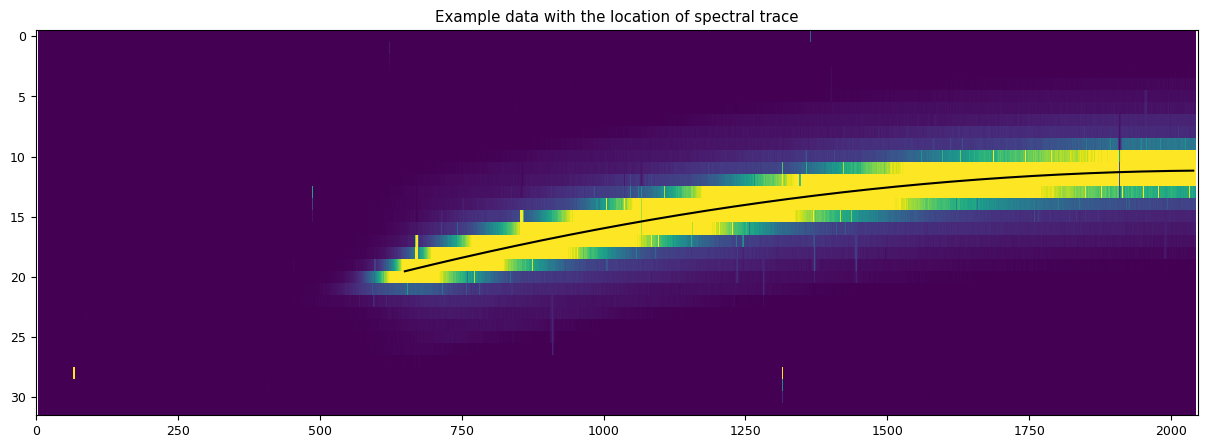

In [4]:
# Finding trace
cent_cub1 = poetss.find_trace_cof(clean_cube=corrected_data[:,:,xstart:xend], margin=5)
trace1, dx1 = poetss.fit_multi_trace(cent_mat=cent_cub1, deg=2, clip=3)
xpos = np.arange(xstart, xend, 1)

ypos2d = np.zeros((corrected_data.shape[0], len(xpos)))
for i in range(ypos2d.shape[0]):
    ypos2d[i,:] = trace1 + dx1[i]

plt.figure(figsize=(15,5))
im = plt.imshow(corrected_data[nint,:,:], interpolation='none', aspect='auto')
im.set_clim([0,1e2])
plt.plot(xpos, trace1, 'k-')
plt.title('Example data with the location of spectral trace')

What we plot above is the median trace location -- on the top of this there should be a jitter of trace as a function of time. Let's plot that jitter below:

Text(0, 0.5, 'Jitter')

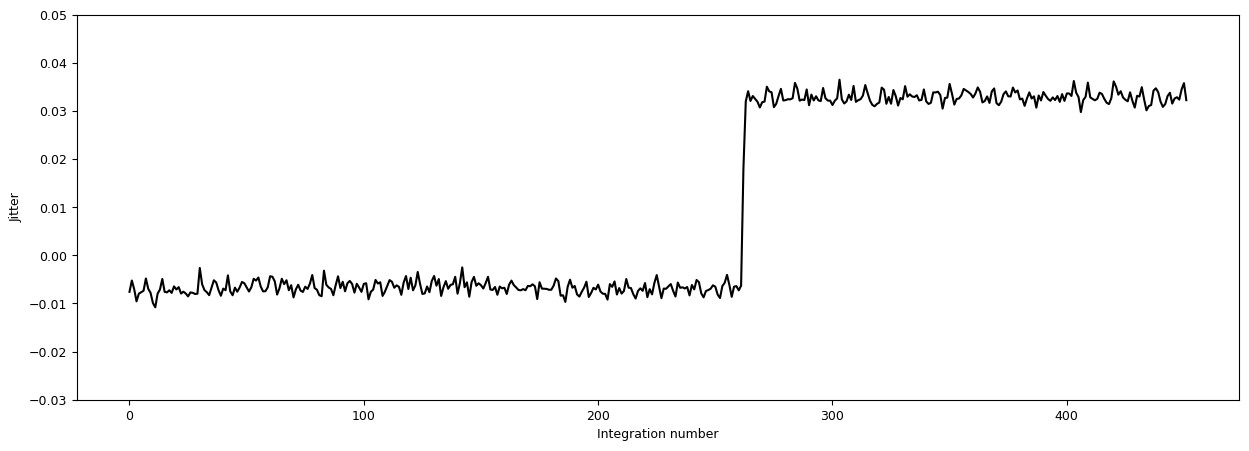

In [5]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(dx1)), dx1, 'k-')
plt.ylim([-0.03,0.05])
plt.xlabel('Integration number')
plt.ylabel('Jitter')

Although there is a little inherent scatter in the data, there is a jump in jitter after ~275 integration. This may be because of those mirror tilting events.

## Initial estimate of PSF

We mentioned above that while PSF would not change with time, it will change significantly with wavelength. So, we want to fit a 2D spline to get a robust estimate of PSF. However, before doing that, let's approximate that the PSF doesn't change with wavelength. This assumption can give us a first rough estimate of stellar spectra which we can use as normalisation constant in next step.

So, let's fit 1D spline to the data as a function of spatial coordinate, i.e., distance from trace. In `stark` we first create a `stark` data object using `SingleOrderPSF` class which will load data. This class will take the data, variance, masked pixels, aperture half-widths and trace locations as inputs. Note that the `SingleOrderPSF` takes 3D arrays as data, variance and masked pixels with dimensions of (nFrames, nRows, nCols) assuming the trace run along the row. Similarly trace locations are a 2D array giving trace positions for each integration (nFrames, TraceLocations).

Once we load the data, we can fit a 1D spline using `univariate_psf_frame` method, which will return PSF frame and best-fitted spline object.

Iter 1 / 3: 5.91860 per cent masked.
Iter 2 / 3: 6.08608 per cent masked.
Iter 3 / 3: 6.14531 per cent masked.


Text(0, 0.5, 'Normalised flux')

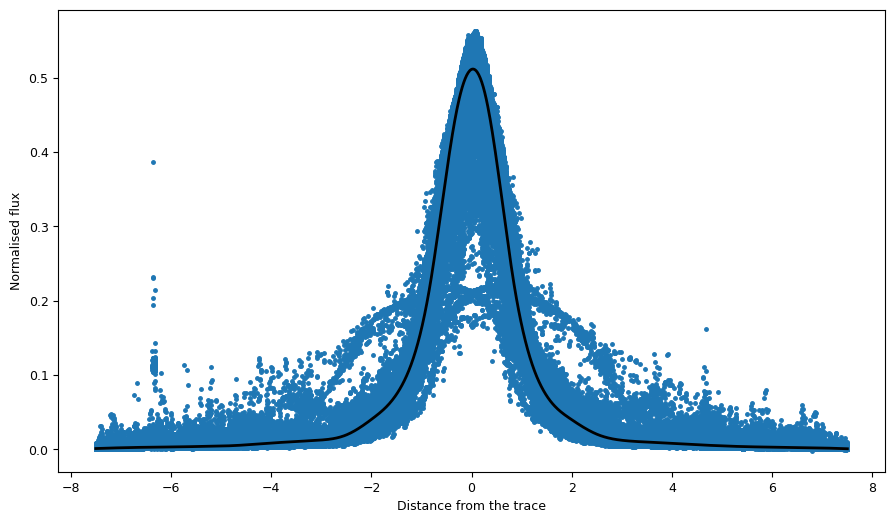

In [6]:
data1d = SingleOrderPSF(frame=corrected_data[:,:,xpos[0]:xpos[-1]+1],\
                        variance=corrected_errs[:,:,xpos[0]:xpos[-1]+1]**2,\
                        ord_pos=ypos2d, ap_rad=aprad, mask=mask_bcr[:,:,xpos[0]:xpos[-1]+1])
psf_frame1d, psf_spline1d, msk_updated_1d = data1d.univariate_psf_frame(niters=3, oversample=2, clip=7)

ts1 = np.linspace(np.min(data1d.norm_array[:,0]), np.max(data1d.norm_array[:,0]), 1000)
msk1 = np.asarray(data1d.norm_array[:,4], dtype=bool)
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(data1d.norm_array[msk1,0], data1d.norm_array[msk1,1], fmt='.')
plt.plot(ts1, psf_spline1d(ts1), c='k', lw=2., zorder=10)
plt.xlabel('Distance from the trace')
plt.ylabel('Normalised flux')

Nice! Above plot shows all data points (in blue) as a function of distance from trace and black line is the best-fitted PSF. This is _very_ interesting -- because it looks like the shape of the PSF changes after a while and that may be apparent in the figure above.

As a first estimate this is almost as good as it can be. The PSF-fitting procedure from above also updated the bad-pixel map since we performed sigma clipping while fitting the PSF. So, let's first update the bad-pixel map.

Text(0.5, 1.0, 'Updated bad-pixel map')

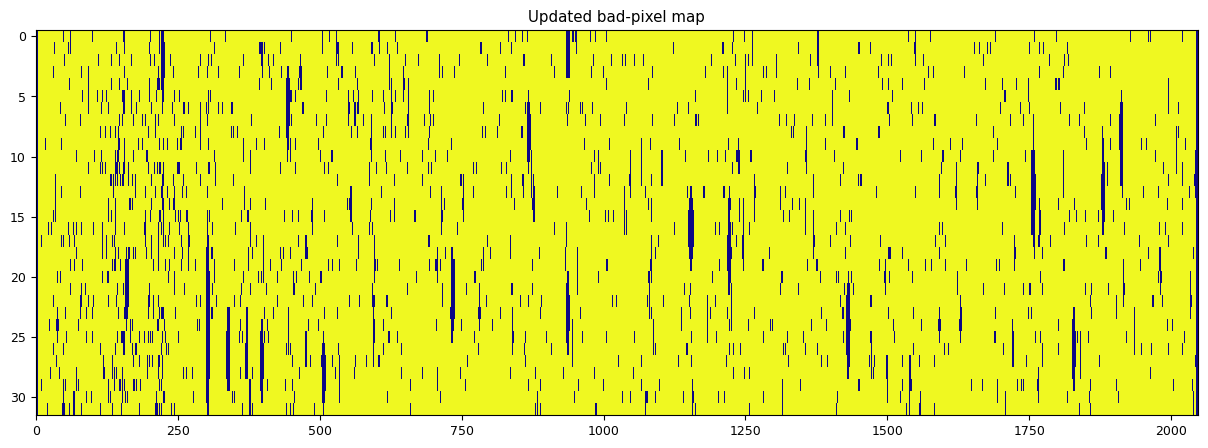

In [7]:
msk_2d = data1d.table2frame(msk_updated_1d)
mask_badpix_updated = np.copy(mask_bcr)
mask_badpix_updated[:,:,xpos[0]:xpos[-1]+1] = mask_bcr[:,:,xpos[0]:xpos[-1]+1] * msk_2d

plt.figure(figsize=(15,5))
plt.imshow(mask_badpix_updated[0,:,:], interpolation='none', cmap='plasma', aspect='auto')
plt.title('Updated bad-pixel map')

Let's now use this PSF to find timeseries of stellar spectra using `optimal_extract` function.

In [8]:
spec1d, var1d = np.zeros((psf_frame1d.shape[0], psf_frame1d.shape[2])), np.zeros((psf_frame1d.shape[0], psf_frame1d.shape[2]))
syth1d = np.zeros(psf_frame1d.shape)
for inte in tqdm(range(spec1d.shape[0])):
    spec1d[inte,:], var1d[inte,:], syth1d[inte,:,:] = optimal_extract(psf_frame=psf_frame1d[inte,:,:],\
                                                                      data=corrected_data[inte,:,xpos[0]:xpos[-1]+1],\
                                                                      variance=corrected_errs[inte,:,xpos[0]:xpos[-1]+1]**2,\
                                                                      mask=mask_badpix_updated[inte,:,xpos[0]:xpos[-1]+1],\
                                                                      ord_pos=ypos2d[inte,:], ap_rad=aprad)

100%|██████████| 452/452 [00:12<00:00, 36.62it/s]


Text(0.5, 1.0, 'Timeseries of spectra')

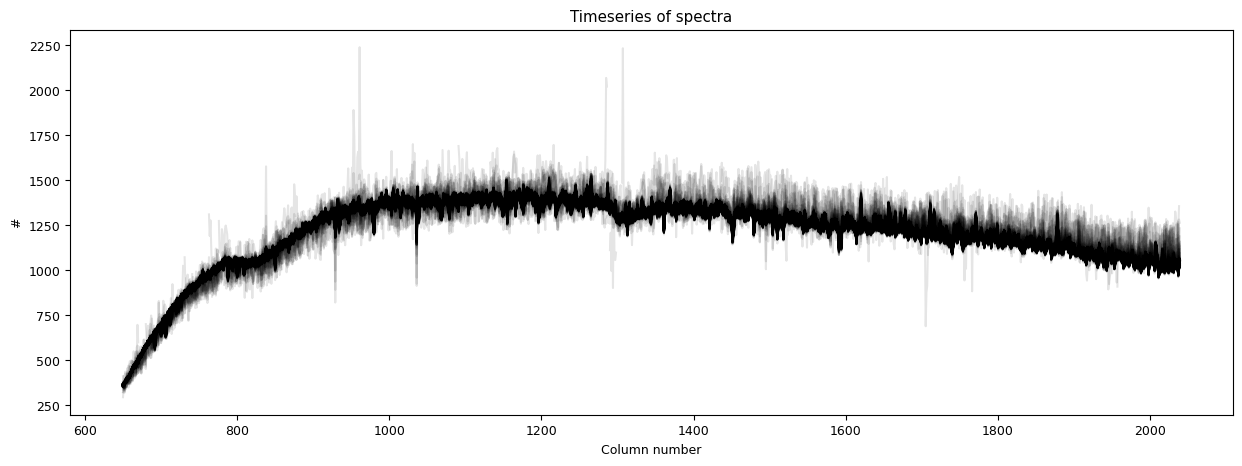

In [9]:
plt.figure(figsize=(15,5))
for i in range(spec1d.shape[0]):
    plt.plot(xpos, spec1d[i,:], 'k', alpha=0.1)
plt.xlabel('Column number')
plt.ylabel('#')
plt.title('Timeseries of spectra')

We now have a first estimate of timeseries of stellar spectra. We can use this as a normalising contant in the next step.

## Robust estimate of PSF

As already mentioned, while PSF doesn't change much with time, it does change with wavelength. So, our above approximation of assuming a constant PSF with wavelength was not good. To take care of this, we will now assume that PSF changes with wavelength and we will fit a 2D spline to the data as a function of spatial direction and wavelength. To do so, we will first load the data as previously, but now we will provide initial estimate of spectra to use it as a normalising constant.

After loading the data we will use `bivariate_psf_frame` method to fit 2D spline to this data:

In [10]:
data2 = SingleOrderPSF(frame=corrected_data[:,:,xpos[0]:xpos[-1]+1],\
                       variance=corrected_errs[:,:,xpos[0]:xpos[-1]+1]**2,\
                       ord_pos=ypos2d, ap_rad=aprad, mask=mask_badpix_updated[:,:,xpos[0]:xpos[-1]+1],\
                       spec=spec1d)
psf_frame2d, psf_spline2d, msk_after2d = data2.bivariate_psf_frame(niters=3, oversample=2, knot_col=10, clip=7)

Iter 1 / 3: 6.20040 per cent masked.
Iter 2 / 3: 6.21776 per cent masked.
Iter 3 / 3: 6.22579 per cent masked.


Before finding the time-series of spectra, let's see how we well we fit the splines. For this, we will visualise data and fitted splines for one given colum.

Text(0, 0.5, 'Normalised flux')

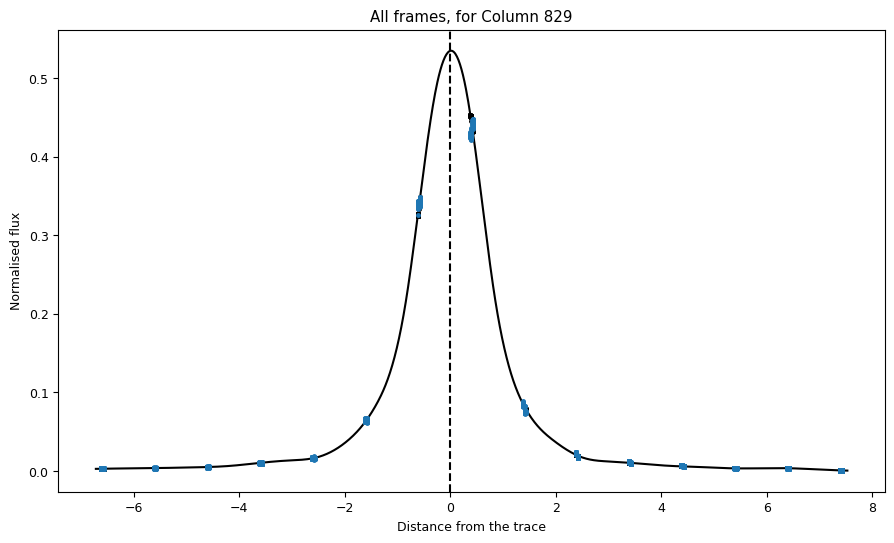

In [11]:
ncol = np.random.choice(xpos)
des_pts, cont_pts = utils.spln2d_func(ncol1=ncol-xpos[0], datacube=data2)
fits_2d = psf_spline2d(cont_pts[0], cont_pts[1], grid=False)

plt.figure(figsize=(16/1.5,9/1.5))
plt.errorbar(des_pts[0], des_pts[2], fmt='.')
plt.plot(cont_pts[0], fits_2d, 'k-')
plt.plot(des_pts[0], psf_spline2d(des_pts[0], des_pts[1], grid=False), 'k.')
plt.axvline(0., color='k', ls='--')
plt.title('All frames, for Column ' + str(ncol))
plt.xlabel('Distance from the trace')
plt.ylabel('Normalised flux')

The blue and black (barely visible) points are original data points and their estimated value based on the best fitted spline (black line). The fitted spline is slightly asymmetric but that is okay. Overall, we did a good job.

Now, we mentioned that the main reason to use 2D splines was that the PSF was not constant as a function of wavelength. So, let's now see how PSF (i.e., its amplitude and FWHM) changes with wavelength.

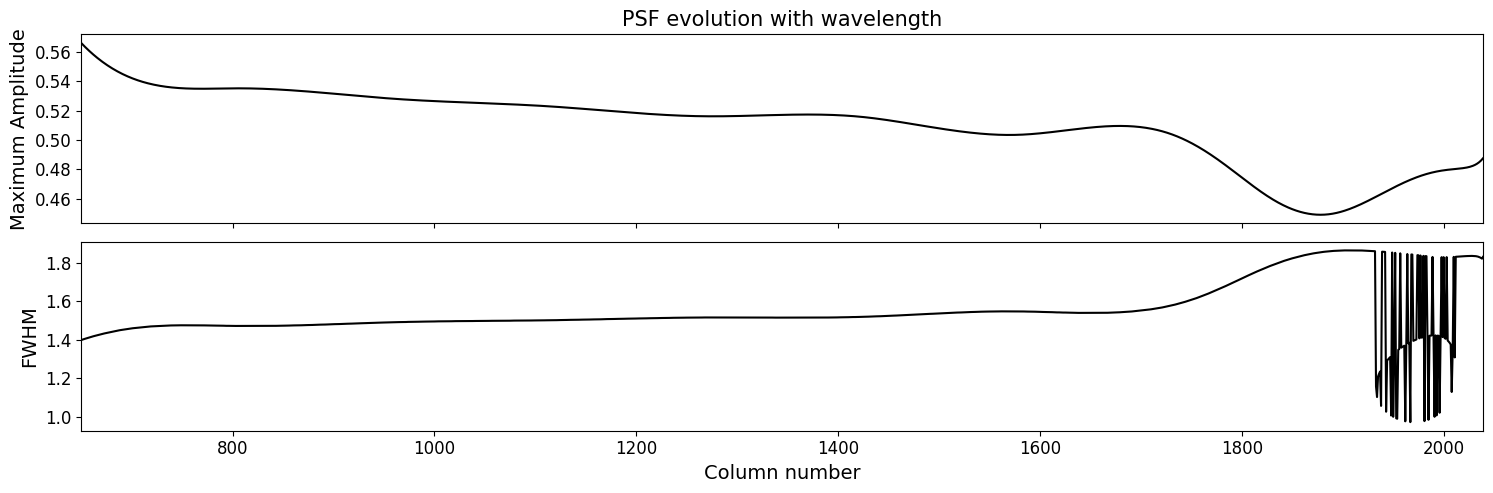

In [12]:
# Defining pixel coordinates
pix_cor_res = 50000
pix_corr = np.linspace(-7., 7., pix_cor_res)

cols = xpos - xpos[0]
max_amp = np.zeros(len(cols))
fwhm = np.zeros(len(cols))

for i in range(len(cols)):
    fit2 = psf_spline2d(x=pix_corr, y=np.ones(pix_cor_res)*cols[i], grid=False)
    # Maximum amplitude
    max_amp[i] = np.max(fit2)
    # Maximum amplitude location
    idx_max_amp = np.where(fit2 == np.max(fit2))[0][0]
    # fwhm
    hm = (np.max(fit2) + np.min(fit2))/2
    idx_hm = np.where(np.abs(fit2 - hm)<0.005)[0]
    idx_hm_up, idx_hm_lo = 0, 0
    diff_up1, diff_lo1 = 10., 10.
    for j in range(len(idx_hm)):
        if idx_hm[j] > idx_max_amp:
            diff_u1 = np.abs(fit2[idx_hm[j]] - hm)
            if diff_u1 < diff_up1:
                diff_up1 = diff_u1
                idx_hm_up = idx_hm[j]
        else:
            diff_l1 = np.abs(fit2[idx_hm[j]] - hm)
            if diff_l1 < diff_lo1:
                diff_lo1 = diff_l1
                idx_hm_lo = idx_hm[j]
    fwhm[i] = np.abs(pix_corr[idx_hm_up] - pix_corr[idx_hm_lo])

fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True, facecolor='white')

axs[0].plot(xpos, max_amp, 'k-')
axs[0].set_ylabel('Maximum Amplitude', fontsize=14)

axs[1].plot(xpos, fwhm, 'k-')
axs[1].set_ylabel('FWHM', fontsize=14)
axs[1].set_xlabel('Column number', fontsize=14)

axs[1].set_xlim([xpos[0], xpos[-1]])

axs[0].set_title('PSF evolution with wavelength', fontsize=15)

plt.setp(axs[0].get_yticklabels(), fontsize=12)
plt.setp(axs[1].get_xticklabels(), fontsize=12)
plt.setp(axs[1].get_yticklabels(), fontsize=12)

plt.tight_layout()

That's a bit odd -- in the last few iterations, FWHM changes abruptly. This maybe because we used `oversample=2` while fitting the 2D spline. When we do this, we put 2 times more knots in the spatial direction, and this could make PSF more noisy (or, more wiggly). One can use `oversample=1` (the default option) which would put 1 knot per pixel -- while this could "stablise" the PSF, its fitting to the data will not be as good. Ideally, one should use `oversample=1` and then repeat this whole procedure iteratively. But, for our purposes, using `oversample=2` is okay.

Again, we will update the mask since we performed a sigma-clipping when fitting a 2D spline.

Text(0.5, 1.0, 'Updated bad-pixel map')

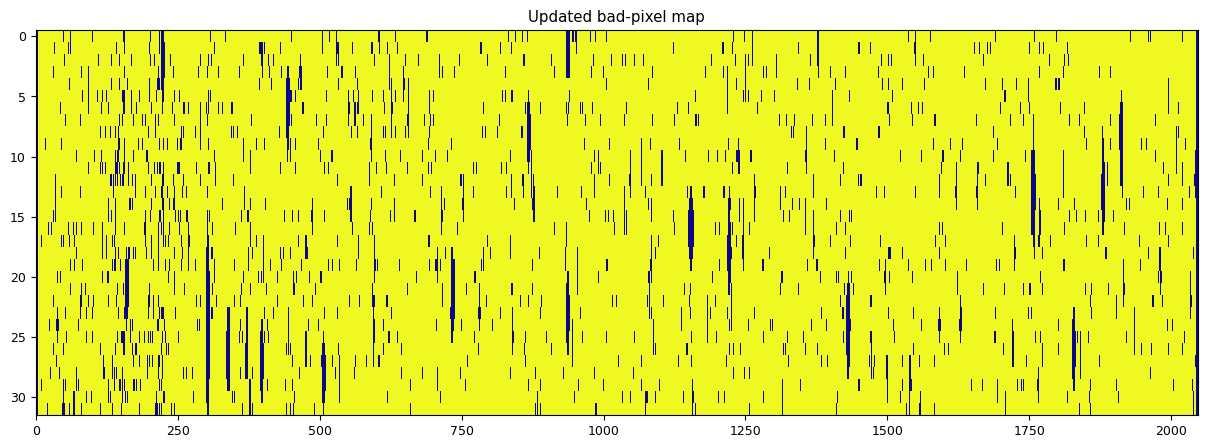

In [13]:
msk_2d2d = data2.table2frame(msk_after2d)
mask_badpix_updated2d = np.copy(mask_badpix_updated)
mask_badpix_updated2d[:,:,xpos[0]:xpos[-1]+1] = mask_badpix_updated[:,:,xpos[0]:xpos[-1]+1] * msk_2d2d

plt.figure(figsize=(15,5))
plt.imshow(mask_badpix_updated2d[0,:,:], interpolation='none', cmap='plasma', aspect='auto')
plt.title('Updated bad-pixel map')

### Aperture half-width selection

Now, we want to use this PSF to extract the stellar spectra. Until now, we were using aperture half-width of 9 pixels to fit the splines and to extract the spectra. And that is totally fine. However, it could be possible that by changing the aperture half-width one could get a lower scatter in the final white-light lightcurve. So, what we will do below is to extract spectra for a series of aperture half-widths from 2 to 9 pixels. After spectral extraction we will compute a white-light lightcurve by taking weighted average of all spectroscopic lightcurves (i.e., flux as a function of time for each wavelengths). Finally, we will compute the MAD of this lightcurve and compare it with MAD value of white-light lightcurves found with different apertures. We will select the aperture with minimum MAD on white-light lightcurve.

100%|██████████| 452/452 [00:13<00:00, 34.70it/s]


Text(0, 0.5, 'MAD of white-light lightcurve')

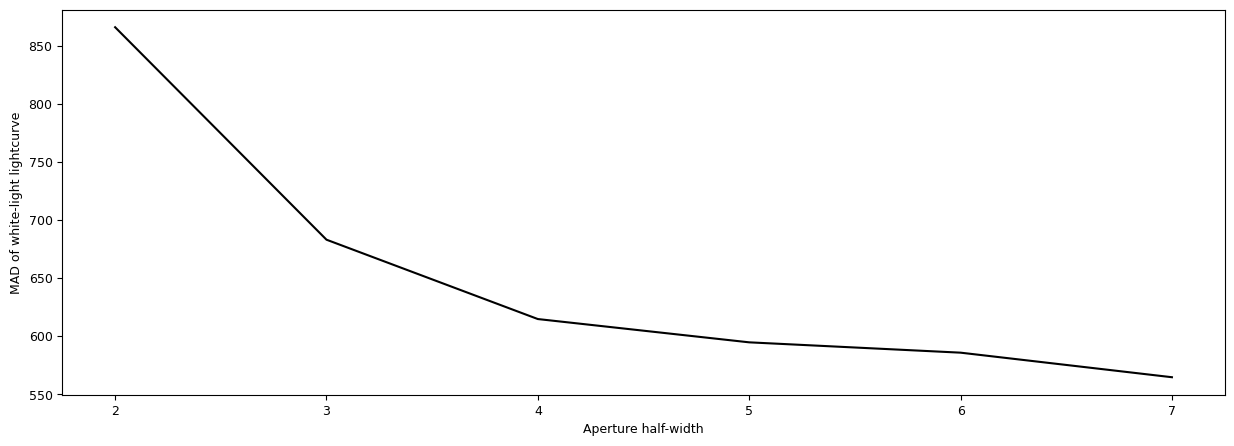

In [14]:
apertures = np.arange(2,aprad+1,1)
scatter = np.zeros(len(apertures))

for aps in range(len(apertures)):
    spec1d, var1d = np.zeros((psf_frame2d.shape[0], psf_frame2d.shape[2])), np.zeros((psf_frame2d.shape[0], psf_frame2d.shape[2]))
    syth1d = np.zeros(psf_frame2d.shape)
    for inte in tqdm(range(spec1d.shape[0])):
        spec1d[inte,:], var1d[inte,:], syth1d[inte,:,:] = optimal_extract(psf_frame=psf_frame2d[inte,:,:],\
                                                                          data=corrected_data[inte,:,xpos[0]:xpos[-1]+1],\
                                                                          variance=corrected_errs[inte,:,xpos[0]:xpos[-1]+1]**2,\
                                                                          mask=mask_badpix_updated2d[inte,:,xpos[0]:xpos[-1]+1],\
                                                                          ord_pos=ypos2d[inte,:], ap_rad=apertures[aps])
    # Computing white-light lightcurve
    wht_lc, wht_err = poetss.white_light(spec1d, np.sqrt(var1d))
    # And its scatter
    scatter[aps] = pipe_mad(wht_lc/np.nanmedian(wht_lc)) * 1e6

plt.figure(figsize=(15,5))
plt.plot(apertures, scatter, 'k-')
plt.xlabel('Aperture half-width')
plt.ylabel('MAD of white-light lightcurve')

Perfect! We now have an optimal aperture size. We will use this aperture size to extract spectra again:

In [15]:
min_scat_ap = apertures[np.argmin(scatter)]

spec1d, var1d = np.zeros((psf_frame2d.shape[0], psf_frame2d.shape[2])), np.zeros((psf_frame2d.shape[0], psf_frame2d.shape[2]))
syth1d = np.zeros(psf_frame2d.shape)
for inte in tqdm(range(spec1d.shape[0])):
    spec1d[inte,:], var1d[inte,:], syth1d[inte,:,:] = optimal_extract(psf_frame=psf_frame2d[inte,:,:],\
                                                                      data=corrected_data[inte,:,xpos[0]:xpos[-1]+1],\
                                                                      variance=corrected_errs[inte,:,xpos[0]:xpos[-1]+1]**2,\
                                                                      mask=mask_badpix_updated2d[inte,:,xpos[0]:xpos[-1]+1],\
                                                                      ord_pos=ypos2d[inte,:], ap_rad=min_scat_ap)

100%|██████████| 452/452 [00:12<00:00, 35.75it/s]


Let's plot all spectra (extracted at different times) on the top of each other:

Text(0.5, 1.0, 'Timeseries of spectra')

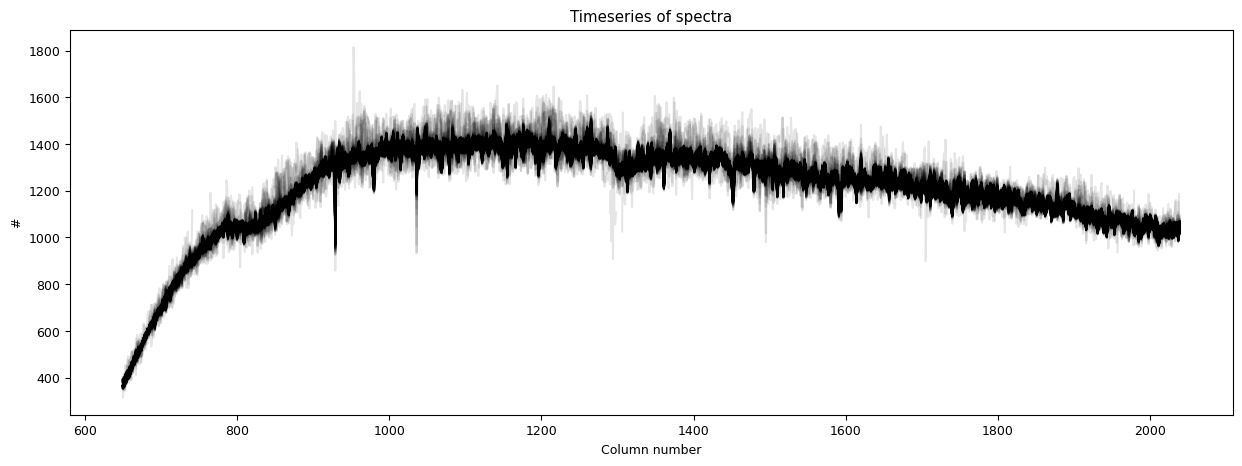

In [16]:
plt.figure(figsize=(15,5))
for i in range(spec1d.shape[0]):
    plt.plot(xpos, spec1d[i,:], 'k', alpha=0.1)
plt.xlabel('Column number')
plt.ylabel('#')
plt.title('Timeseries of spectra')

Good! The scatter (or the width) that we see above is because the level of flux changes during the transit event.

### Residual frame

When we fit 2D spline to the data, we are basically modelling the trace. So, in principle, we do spectral extraction, we should have a synthetic model of the data. Indeed, we were saving this model for each time when we performed spectral extraction using `optimal_extract` function. We can subtract this sythetic model from our dataset to find what is called residual frame. Ideally, this frame should look like a white-noise. If not there is some left-over noise in the data or spline fitting was not perfect. 

In any case the median residual frame should show us the static leftover noise that was not fitted. If one find any such noise one can subtract this median residual frame from our original data and repeat the whole procedure of spline fitting until there remains only white noise in the median residual frame.

So, now, let's see how the median residual frame looks like:

Text(0.5, 1.0, 'Median residual frame')

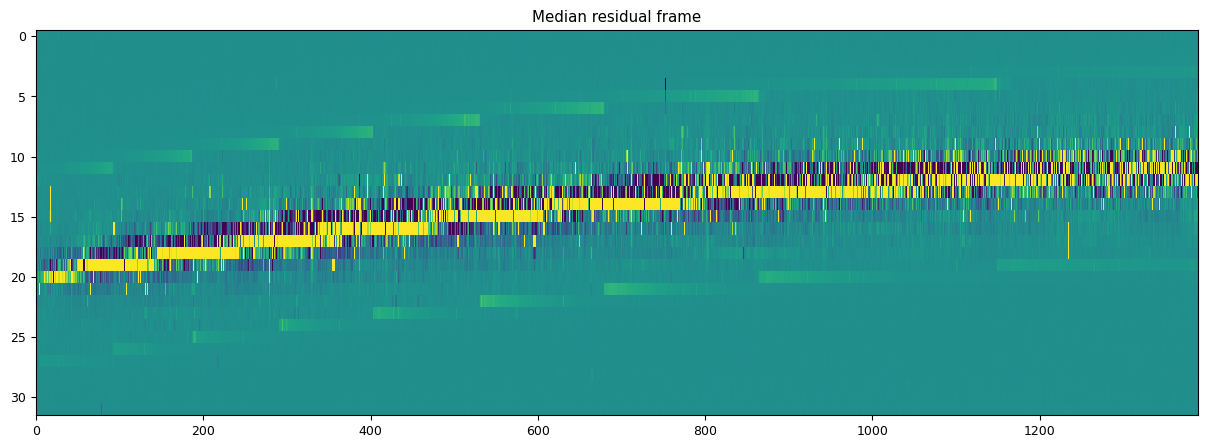

In [17]:
resid1 = np.zeros(syth1d.shape)
for j in range(resid1.shape[0]):
    resid1[j,:,:] = corrected_data[j,:,xpos[0]:xpos[-1]+1] - syth1d[j,:,:]

med_resid = np.nanmedian(resid1, axis=0)

plt.figure(figsize=(15,5))
im = plt.imshow(med_resid, interpolation='none', aspect='auto')
im.set_clim([-5,5])
#plt.xlim([0,315])
#plt.ylim([20,40])
plt.title('Median residual frame')

Ahh good! Maybe there is some structure in these image -- but for the purpose of this analysis, we can safely assume that this is just some white-noise. Interested reader can subtract this median residual image from each dataframe and repeat the whole procedure of spline fitting again. That would definately remove any leftover static noise.

### Lightcurves

Now, we will compute white-light lightcurve by taking a weighted average of spectroscopic lightcurves (i.e., timeseries of flux at each wavelength). `poetss` has an inbuilt function for this which we will use below.

Text(0, 0.5, 'Relative flux')

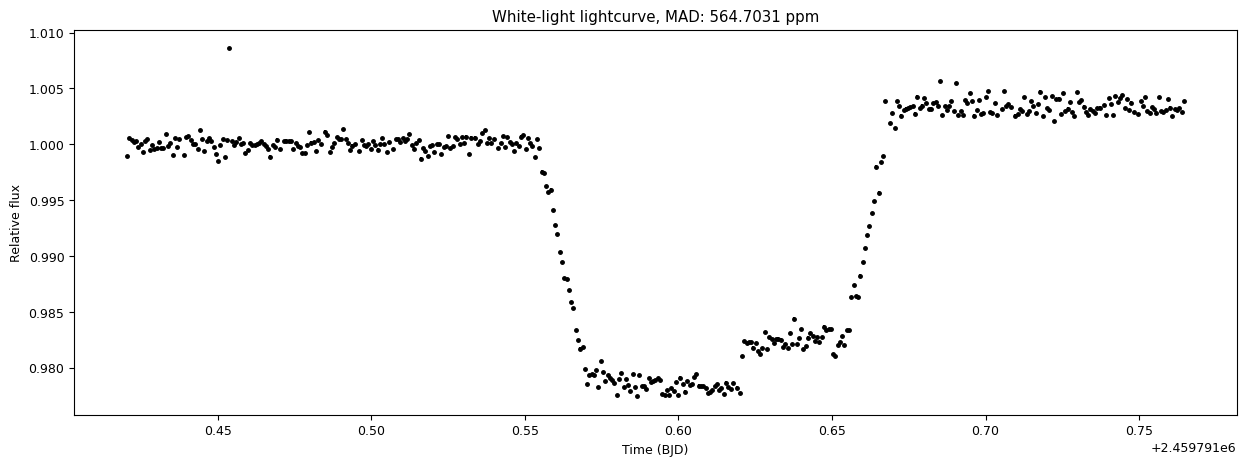

In [18]:
wht_light_lc, wht_light_err = poetss.white_light(spec1d, np.sqrt(var1d))

plt.figure(figsize=(15,5))
plt.errorbar(time_bjd, wht_light_lc/np.nanmedian(wht_light_lc), \
             yerr=wht_light_err/np.nanmedian(wht_light_lc), fmt='.', c='k')
plt.title('White-light lightcurve, MAD: {:.4f} ppm'.format(pipe_mad(wht_light_lc/np.nanmedian(wht_light_lc)) * 1e6))
plt.xlabel('Time (BJD)')
plt.ylabel('Relative flux')

This is interesting! The is a flux jump near the mid-transit: that is supposed to be a result of a mirror-tilting event. In another notebook (p4.ipynb) we will demonstrate how one can use principal component analysis to find the location of mirror tilting event. But it is actually fairly obvious from the figure above. So, when we will fit a transit lightcurve to this data, we will simply use a step function as a regressor to take care of this.

Before doing this, let's see how the spectroscopic lightcurves looks like:

Text(0, 0.5, 'ppm')

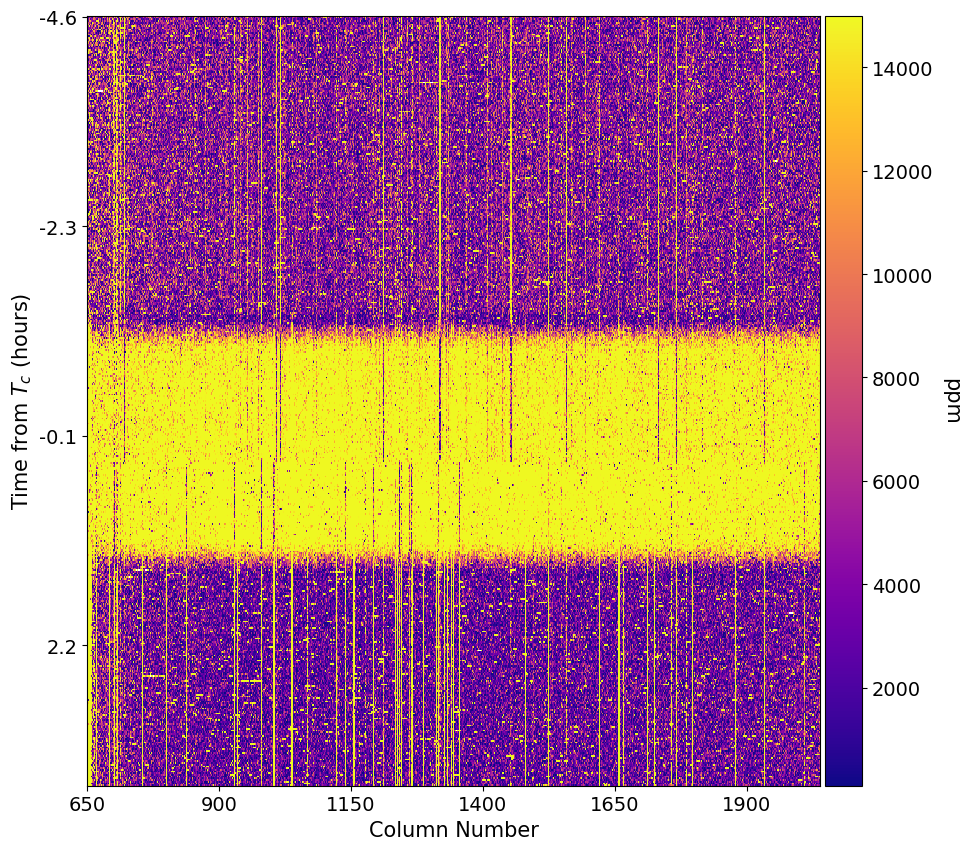

In [19]:
per, tc = 4.05527892, 2456401.39763
cycle = round((time_bjd[0] - tc) / per)
tc1 = tc + (cycle * per)
times_hours = (time_bjd - tc1) * 24

norm_lcs = np.zeros(spec1d.shape)
for i in range(norm_lcs.shape[1]):
    norm_lc1 = spec1d[:,i] / np.nanmedian(spec1d[:,i])
    norm_lcs[:,i] = (norm_lc1 - 1)*1e6

fig, ax1 = plt.subplots(figsize=(10, 10))

# Data
im1 = ax1.imshow(np.abs(norm_lcs), interpolation='none', cmap='plasma', aspect = 'auto')
im1.set_clim(100,15000)
plt.xlabel('Column Number', fontsize = 15)
plt.ylabel('Time from $T_c$ (hours)', fontsize = 15)

# X axis:
ticks = np.arange(0, len(xpos), 250)
ticklabels = ["{:0.0f}".format(xpos[i]) for i in ticks]
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticklabels, fontsize=14)

# Y axis:
ticks = np.arange(0, len(time_bjd), 123)
ticklabels = ["{:.1f}".format(times_hours[i]) for i in ticks]
ax1.set_yticks(ticks)
ax1.set_yticklabels(ticklabels, fontsize=14)

# Colorbar:
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im1, shrink = 0.08, cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('ppm', rotation=270, fontsize = 15)

Okay, it is noisy, but nothing I did not expect.

## White-light lightcurve fitting

Now, we will fit transit model to the white-light lightcurve. In addition to the transit model, we will fit a linear model in time (to take care of any long-term trend) and linear model in trace positions.

In [20]:
# ------- Defining the dataset:
tim, fl, fle = {}, {}, {}
lin_pars = {}

tim[visit], fl[visit], fle[visit] = time_bjd, wht_light_lc/np.nanmedian(wht_light_lc), \
                                    wht_light_err/np.nanmedian(wht_light_lc)
step1, step2 = np.ones(len(time_bjd)), np.ones(len(time_bjd))
step1[0:261], step2[263:] = 0., 0.
lins1 = np.vstack([ (time_bjd-np.median(time_bjd))/mad_std(time_bjd), step1, step2])
lin_pars[visit] = np.transpose(lins1)

# ------- Defining the priors
## Some planetary parameters
per, per_err = 4.05527892, 0.00000086                       # Ivshina & Winn 2022
bjd0, bjd0_err = 2456401.39763, 0.00013                     # Ivshina & Winn 2022
ar, ar_err = 11.55, 0.13                                    # Fischer et al. 2016
inc, inc_err = 87.32, 0.17                                  # Mancini et al. 2018
bb, bb_err = 0.447, (0.041+0.055)/2                         # Maciejewski et al. 2016
ecc, omega = 0., 90.                                        # Faedi et al. 2011

cycle = round((tim[visit][0]-bjd0)/per)
tc1 = np.random.normal(bjd0, bjd0_err, 100000) + (cycle*np.random.normal(per, per_err, 100000))

par_P = ['P_p1', 't0_p1', 'b_p1', 'q1_' + visit, 'q2_' + visit, 'ecc_p1', 'omega_p1', 'a_p1']
dist_P = ['fixed', 'normal', 'truncatednormal', 'uniform', 'uniform', 'fixed', 'fixed', 'normal']
hyper_P = [per, [np.median(tc1), np.std(tc1)], [bb, 3*bb_err, 0., 1.], [0., 1.], [0., 1.], ecc, omega, [ar, 3*ar_err]]
if not catwoman:
    par_P = par_P + ['p_p1_' + visit]
    dist_P = dist_P + ['uniform']
    hyper_P = hyper_P + [[0., 1.]]
else:
    par_P = par_P + ['p1_p1_' + visit, 'p2_p1_' + visit, 'phi_p1']
    dist_P = dist_P + ['uniform', 'uniform', 'fixed']
    hyper_P = hyper_P + [[0., 1.], [0., 1.], 90.]

### Instrumental and linear parameters
par_lin, dist_lin, hyper_lin = [], [], []
### Instrumental parameters
par_ins = ['mdilution_' + visit, 'mflux_' + visit, 'sigma_w_' + visit]
dist_ins = ['fixed', 'normal', 'loguniform']
hyper_ins = [1.0, [0., 0.1], [0.1, 10000.]]
### Linear parameters
for j in range(lin_pars[visit].shape[1]):
    par_lin.append('theta' + str(j) + '_' + visit)
    dist_lin.append('uniform')
    hyper_lin.append([-1., 1.])

## Total priors
par_tot = par_P + par_ins + par_lin
dist_tot = dist_P + dist_ins + dist_lin
hyper_tot = hyper_P + hyper_ins + hyper_lin

priors = juliet.utils.generate_priors(par_tot, dist_tot, hyper_tot)


# ------- And, fitting
dataset = juliet.load(priors=priors, t_lc=tim, y_lc=fl, yerr_lc=fle, linear_regressors_lc=lin_pars,\
                      out_folder=p1 + '/NRSG395H/Analysis/White-light-' + detector)
res = dataset.fit(sampler = 'dynesty', nthreads=8)

29550it [01:07, 435.53it/s, +500 | bound: 351 | nc: 1 | ncall: 884670 | eff(%):  3.399 | loglstar:   -inf < 2606.436 <    inf | logz: 2547.954 +/-  0.344 | dlogz:  0.001 >  0.509] 


Let's plot the best-fitted models:

In [21]:
# Full model and errors on it
model, model_uerr, model_derr, comps = res.lc.evaluate(visit, return_err=True, return_components=True)

# Out-of-transit baseline flux
mflx = np.median(res.posteriors['posterior_samples']['mflux_' + visit])

# Detrended flux
fl9 = (fl[visit] - comps['lm']) * (1 + mflx)

# Detrended error
errs1 = np.median(res.posteriors['posterior_samples']['sigma_w_' + visit] * 1e-6)
fle9 = np.sqrt((errs1**2) + (fle[visit]**2))

# Residuals
resid = (fl[visit]-model)*1e6

# Transit model
tmodel = (model - comps['lm']) * (1 + mflx)

[None, None, None, None, None]

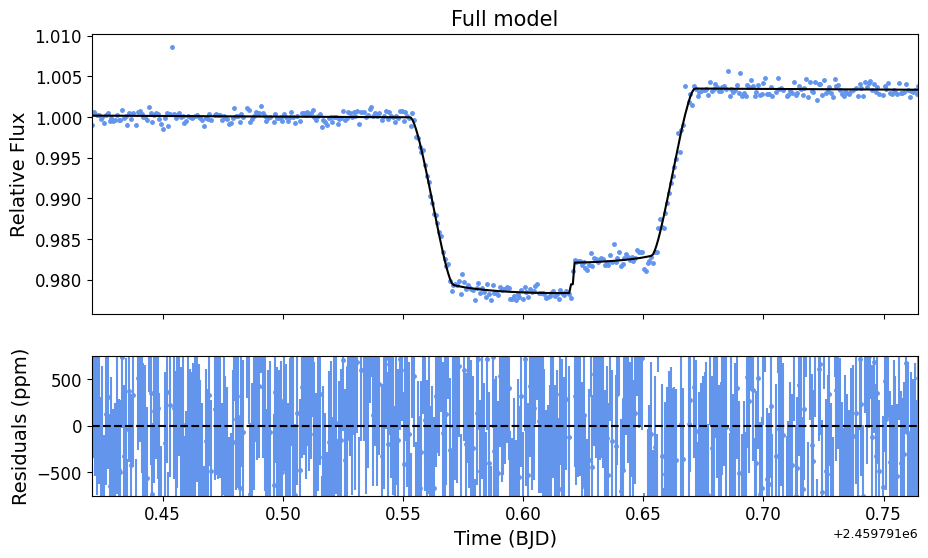

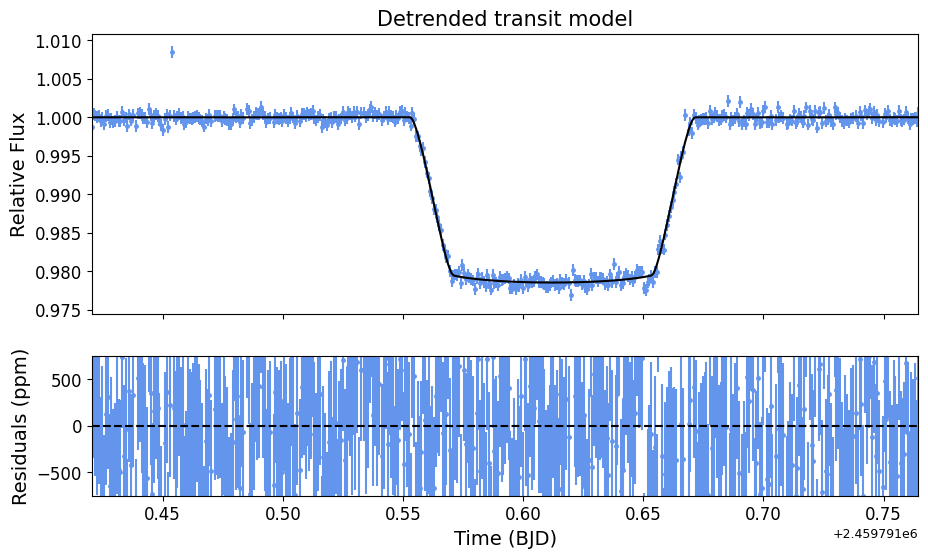

In [22]:
# For Full model
fig = plt.figure(figsize=(16/1.5,9/1.5))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim[visit], fl[visit], yerr=fle[visit], fmt='.', c='cornflowerblue')
ax1.plot(tim[visit], model, c='k', zorder=100)
ax1.set_ylabel('Relative Flux', fontsize=14)
ax1.set_xlim(np.min(tim[visit]), np.max(tim[visit]))
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.set_title('Full model', fontsize=15)

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim[visit], resid, yerr=fle9*1e6, c='cornflowerblue', fmt='.')
ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
ax2.set_ylabel('Residuals (ppm)', fontsize=14)
ax2.set_xlabel('Time (BJD)', fontsize=14)
ax2.set_ylim(-750,750)
ax2.set_xlim(np.min(tim[visit]), np.max(tim[visit]))
plt.setp(ax2.get_xticklabels(), fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)


# For Detrended
fig = plt.figure(figsize=(16/1.5,9/1.5))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim[visit], fl9, yerr=fle9, fmt='.', c='cornflowerblue')
ax1.plot(tim[visit], tmodel, c='k', zorder=100)
ax1.set_ylabel('Relative Flux', fontsize=14)
ax1.set_xlim(np.min(tim[visit]), np.max(tim[visit]))
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.set_title('Detrended transit model', fontsize=15)

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim[visit], resid, yerr=fle9*1e6, c='cornflowerblue', fmt='.')
ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
ax2.set_ylabel('Residuals (ppm)', fontsize=14)
ax2.set_xlabel('Time (BJD)', fontsize=14)
ax2.set_ylim(-750,750)
ax2.set_xlim(np.min(tim[visit]), np.max(tim[visit]))
plt.setp(ax2.get_xticklabels(), fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)

Okay, it looks like there is some ramp effect in the beginning and increament of flux at the end of the visit. Okay for now! Let's look at the best-fit parameters:

In [23]:
os.system("cat " + p1 + "/NRSG395H/Analysis/White-light-" + detector + "/posteriors.dat")

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
t0_p1              	 	 2459791.6122446172 	 	 0.0000976166 	 	 0.0000990005
b_p1               	 	 0.4136053462 	 	 0.0230647343 	 	 0.0253922189
q1_NRSG395H        	 	 0.0109254605 	 	 0.0101630297 	 	 0.0052194956
q2_NRSG395H        	 	 0.4684533793 	 	 0.3326902083 	 	 0.2934632459
a_p1               	 	 11.6769311353 	 	 0.1360242649 	 	 0.1301641627
p_p1_NRSG395H      	 	 0.1446955824 	 	 0.0004177680 	 	 0.0004283565
mflux_NRSG395H     	 	 -0.0025853737 	 	 0.0005535096 	 	 0.0005299631
sigma_w_NRSG395H   	 	 758.0265066642 	 	 25.8793082157 	 	 25.4510400741
theta0_NRSG395H    	 	 -0.0002044412 	 	 0.0000977487 	 	 0.0000930976
theta1_NRSG395H    	 	 0.0010563765 	 	 0.0005327936 	 	 0.0005538704
theta2_NRSG395H    	 	 -0.0026811491 	 	 0.0005711452 	 	 0.0005527646


0

Let's compute Allan deviation plot for this data to see the level of noise in the data:

Precision of the lightcurve: 607.3263 ppm
Median errorbar after the fitting: 764.6304 ppm


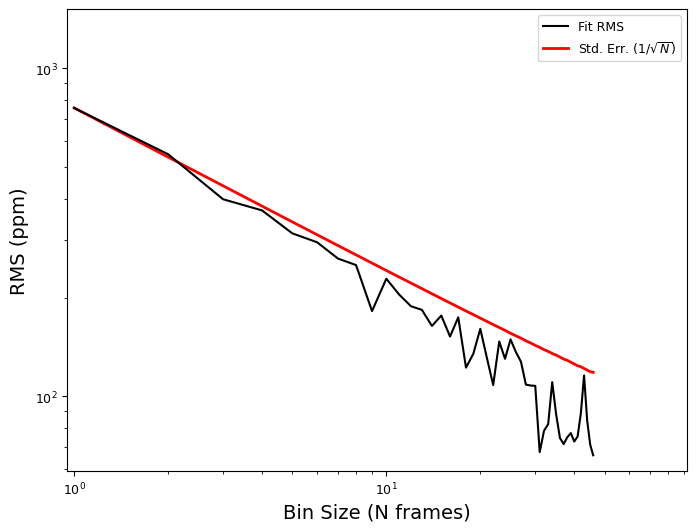

In [24]:
rms, stderr, binsz = utils.computeRMS(resid*1e-6, binstep=1)
normfactor = 1e-6

mad_sigs = mad_std(resid)
print('Precision of the lightcurve: {:.4f} ppm'.format(mad_sigs))
print('Median errorbar after the fitting: {:.4f} ppm'.format(np.nanmedian(fle9)*1e6))

plt.figure(figsize=(8,6))
plt.plot(binsz, rms / normfactor, color='black', lw=1.5,
                label='Fit RMS', zorder=3)
plt.plot(binsz, stderr / normfactor, color='red', ls='-', lw=2,
                label=r'Std. Err. ($1/\sqrt{N}$)', zorder=1)
plt.xlim(0.95, binsz[-1] * 2)
plt.ylim(stderr[-1] / normfactor / 2., stderr[0] / normfactor * 2.)
plt.xlabel("Bin Size (N frames)", fontsize=14)
plt.ylabel("RMS (ppm)", fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')

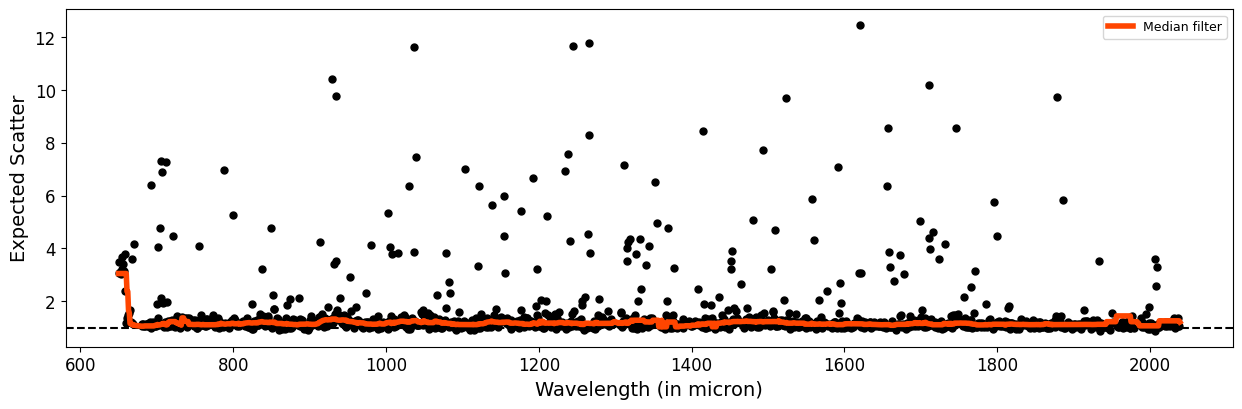

In [25]:
post1 = res.posteriors['posterior_samples']

t14 = tdur(per=per, ar=np.median(post1['a_p1']), rprs=np.median(post1['p_p1_' + visit]), bb=np.median(post1['b_p1']))
phs = juliet.utils.get_phases(tim[visit], per, np.median(tc1))
idx_oot = np.where(np.abs(phs*per) >= 0.5*t14)[0]

scat_data = mad_std(spec1d[idx_oot,:], axis=0)
median_errorbars = np.median(np.sqrt(var1d[idx_oot,:]), axis=0)

ratios = scat_data / median_errorbars

fig, ax = plt.subplots(figsize=(15/1.2,5/1.2))
ax.errorbar(xpos, ratios, fmt='o', color='k')
ax.plot(xpos, median_filter(ratios, size = 41), '-', lw = 4,\
     color ='orangered', label = 'Median filter', zorder=10)
ax.axhline(1., color='k', ls='--')
ax.set_xlabel('Wavelength (in micron)', fontsize=14)
ax.set_ylabel('Expected Scatter', fontsize=14)
ax.legend(loc='best')
#ax.set_ylim([0.96,1.04])
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.tight_layout()

Fantastic! This simply means that scatter in the (out-of-transit) data is more-or-less explained by the errorbars on the data. So all is almost well.

Now, we will not perform spectroscopic lightcurve analysis here. Let's just save our results:

In [ ]:
# Dictionary for saving the final results
dataset = {}
dataset['spectra'] = spec1d
dataset['variance'] = var1d
dataset['resid'] = resid1
dataset['times'] = time_bjd
pickle.dump(dataset, open(pout + '/Spectrum_cube_' + visit + '_' + detector + '.pkl','wb'))

psf_res = {}
psf_res['psf'] = psf_frame2d
psf_res['spline'] = psf_spline2d
pickle.dump(psf_res, open(pout + '/PSF_data_' + visit + '_' + detector + '.pkl','wb'))

pickle.dump(data2, open(pout + '/Dataset2_' + visit + '_' + detector + '.stk','wb'))

np.save(pout + '/xpos_' + detector + '.npy', xpos)
np.save(pout + '/median_trace_' + detector + '.npy', trace1)